In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=ef5110f2a14e14e710131b5284f827fd734760813c1c726b1272a9f08e4fbeef
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession

In [3]:
spark=SparkSession.builder.appName("Fraud-Detection").getOrCreate()

In [4]:
df = spark.read.csv("/content/drive/MyDrive/BDA_PROJECT/PS_20174392719_1491204439457_log.csv", header=True, inferSchema=True)
df.show()

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT|  9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PAYMENT|  1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1| PAYMENT| 11668.14|C2048537720|      41554.0|      29885.86|M123070170

In [5]:
num_rows = df.count()
print("Number of Rows:", num_rows)

Number of Rows: 6362620


In [6]:
num_columns = len(df.columns)
print("Number of Columns:", num_columns)


Number of Columns: 11


In [7]:
df.printSchema()

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)



In [8]:
from pyspark.sql.functions import col, sum
missing_counts = df.agg(*[sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_counts.show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [9]:
df.groupby("isFraud").count().show()

+-------+-------+
|isFraud|  count|
+-------+-------+
|      1|   8213|
|      0|6354407|
+-------+-------+



In [10]:
df.groupby("isFlaggedFraud").count().show()

+--------------+-------+
|isFlaggedFraud|  count|
+--------------+-------+
|             0|6362604|
|             1|     16|
+--------------+-------+



In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = df.select("type", "amount", "oldbalanceOrg", "newbalanceOrig", "isFraud")

In [13]:
minority_df = df.filter(col("isFraud") == 1)
majority_df = df.filter(col("isFraud") == 0)
ratio = minority_df.count() / majority_df.count()
undersampled_majority_df = majority_df.sample(False, ratio, seed=123)
balanced_df = undersampled_majority_df.union(minority_df)

In [14]:
balanced_df.groupBy("isFraud").count().show()

+-------+-----+
|isFraud|count|
+-------+-----+
|      0| 8267|
|      1| 8213|
+-------+-----+



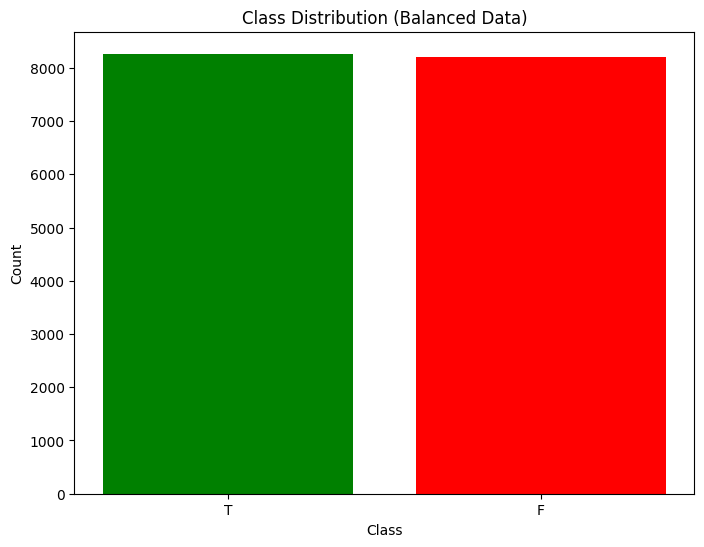

In [15]:
balanced_class_counts = balanced_df.groupBy("isFraud").count().toPandas()
plt.figure(figsize=(8, 6))
plt.bar(balanced_class_counts["isFraud"], balanced_class_counts["count"], color=['green', 'red'])
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution (Balanced Data)")
plt.xticks(balanced_class_counts["isFraud"], ["T", "F"])
plt.show()

In [16]:
df.groupBy('type').count().show()

+--------+-------+
|    type|  count|
+--------+-------+
|TRANSFER| 532909|
| CASH_IN|1399284|
|CASH_OUT|2237500|
| PAYMENT|2151495|
|   DEBIT|  41432|
+--------+-------+



In [17]:
train, test = df.randomSplit([0.7, 0.3], seed=7)

In [18]:
train.dtypes

[('type', 'string'),
 ('amount', 'double'),
 ('oldbalanceOrg', 'double'),
 ('newbalanceOrig', 'double'),
 ('isFraud', 'int')]

In [19]:
catCols = [x for (x, dataType) in train.dtypes if dataType == "string"]
numCols = [ x for (x, dataType) in train.dtypes if (dataType == "double") ]
print(numCols)
print(catCols)

['amount', 'oldbalanceOrg', 'newbalanceOrig']
['type']


In [20]:
from pyspark.ml.feature import (
    OneHotEncoder,
    StringIndexer,
)

In [21]:
string_indexer = [
    StringIndexer(inputCol=x, outputCol=x + "_StringIndexer", handleInvalid="skip")
    for x in catCols
]

In [22]:
string_indexe=string_indexer[0].fit(df).transform(df)
string_indexe.show()


+--------+---------+-------------+--------------+-------+------------------+
|    type|   amount|oldbalanceOrg|newbalanceOrig|isFraud|type_StringIndexer|
+--------+---------+-------------+--------------+-------+------------------+
| PAYMENT|  9839.64|     170136.0|     160296.36|      0|               1.0|
| PAYMENT|  1864.28|      21249.0|      19384.72|      0|               1.0|
|TRANSFER|    181.0|        181.0|           0.0|      1|               3.0|
|CASH_OUT|    181.0|        181.0|           0.0|      1|               0.0|
| PAYMENT| 11668.14|      41554.0|      29885.86|      0|               1.0|
| PAYMENT|  7817.71|      53860.0|      46042.29|      0|               1.0|
| PAYMENT|  7107.77|     183195.0|     176087.23|      0|               1.0|
| PAYMENT|  7861.64|    176087.23|     168225.59|      0|               1.0|
| PAYMENT|  4024.36|       2671.0|           0.0|      0|               1.0|
|   DEBIT|  5337.77|      41720.0|      36382.23|      0|               4.0|

In [23]:

one_hot_encoder = [
    OneHotEncoder(
        inputCols=[f"{x}_StringIndexer" for x in catCols],
        outputCols=[f"{x}_OneHotEncoder" for x in catCols],
    )
]

In [24]:
one_hot_encoder_df=one_hot_encoder[0].fit(string_indexe).transform(string_indexe)
one_hot_encoder_df.show()

+--------+---------+-------------+--------------+-------+------------------+------------------+
|    type|   amount|oldbalanceOrg|newbalanceOrig|isFraud|type_StringIndexer|type_OneHotEncoder|
+--------+---------+-------------+--------------+-------+------------------+------------------+
| PAYMENT|  9839.64|     170136.0|     160296.36|      0|               1.0|     (4,[1],[1.0])|
| PAYMENT|  1864.28|      21249.0|      19384.72|      0|               1.0|     (4,[1],[1.0])|
|TRANSFER|    181.0|        181.0|           0.0|      1|               3.0|     (4,[3],[1.0])|
|CASH_OUT|    181.0|        181.0|           0.0|      1|               0.0|     (4,[0],[1.0])|
| PAYMENT| 11668.14|      41554.0|      29885.86|      0|               1.0|     (4,[1],[1.0])|
| PAYMENT|  7817.71|      53860.0|      46042.29|      0|               1.0|     (4,[1],[1.0])|
| PAYMENT|  7107.77|     183195.0|     176087.23|      0|               1.0|     (4,[1],[1.0])|
| PAYMENT|  7861.64|    176087.23|     1

In [25]:
from pyspark.ml.feature import VectorAssembler

In [26]:
assemblerInput = [x for x in numCols]
assemblerInput += [f"{x}_OneHotEncoder" for x in catCols]

In [27]:
assemblerInput

['amount', 'oldbalanceOrg', 'newbalanceOrig', 'type_OneHotEncoder']

In [28]:
vector_assembler = VectorAssembler(
    inputCols=assemblerInput, outputCol="VectorAssembler_features"
)

In [29]:
stages = []
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]

In [30]:
stages

[StringIndexer_af60676affc4,
 OneHotEncoder_951858b6d5ac,
 VectorAssembler_3dd0a993d567]

In [31]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline


spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

data = spark.read.csv('/content/drive/MyDrive/BDA_PROJECT/PS_20174392719_1491204439457_log.csv', header=True, inferSchema=True)


label_indexer = StringIndexer(inputCol="isFraud", outputCol="label")


feature_columns = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]


assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")


type_indexer = StringIndexer(inputCol="type", outputCol="type_index")
type_encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")


rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="label")


stages = [label_indexer, assembler, type_indexer, type_encoder, rf_classifier]

pipeline = Pipeline(stages=stages)


train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


model = pipeline.fit(train_data)

predictions = model.transform(test_data)

predictions.select("isFraud", "prediction", "probability").show()

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
area_under_roc = evaluator.evaluate(predictions)
print("Area Under ROC:", area_under_roc)


+-------+----------+--------------------+
|isFraud|prediction|         probability|
+-------+----------+--------------------+
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964186651220...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99966175022681...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964186651220...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
|      0|       0.0|[0.99964149949551...|
+-------+----------+--------------

In [32]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator


spark = SparkSession.builder.appName("FraudDetection").getOrCreate()

data = spark.read.csv('/content/drive/MyDrive/BDA_PROJECT/PS_20174392719_1491204439457_log.csv', header=True, inferSchema=True)


label_indexer = StringIndexer(inputCol="isFraud", outputCol="label")

feature_columns = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]


assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

type_indexer = StringIndexer(inputCol="type", outputCol="type_index")
type_encoder = OneHotEncoder(inputCol="type_index", outputCol="type_encoded")


nb_classifier = NaiveBayes(featuresCol="features", labelCol="label")


stages = [label_indexer, assembler, type_indexer, type_encoder, nb_classifier]


pipeline = Pipeline(stages=stages)

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

model = pipeline.fit(train_data)


predictions = model.transform(test_data)


predictions.select("isFraud", "prediction", "probability").show()


evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label")
area_under_roc = evaluator.evaluate(predictions)
print("Area Under ROC:", area_under_roc)




+-------+----------+-----------+
|isFraud|prediction|probability|
+-------+----------+-----------+
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
|      0|       0.0|  [1.0,0.0]|
+-------+----------+-----------+
only showing top 20 rows

Area Under ROC: 0.4425404462374512


In [33]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession

spark1 = SparkSession.builder.appName("fraud").getOrCreate()

data = spark1.read.csv('/content/drive/MyDrive/BDA_PROJECT/PS_20174392719_1491204439457_log.csv', header=True, inferSchema=True)

feature_columns = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]

# Define the target column (the column you want to predict)
target_column = "isFraud"  # Replace with your actual target column name

# Assemble the feature vector with a unique output column name
assembler = VectorAssembler(inputCols=feature_columns, outputCol="my_features")

# Transform your DataFrame
train_data = assembler.transform(train_data).withColumnRenamed(target_column, "label")
test_data = assembler.transform(test_data).withColumnRenamed(target_column, "label")

# Create a NaiveBayes model
nb = NaiveBayes(featuresCol="my_features", labelCol="label")  # Use the assembled features column

# Define the parameter grid for hyperparameter tuning
param_grid = (ParamGridBuilder()
              .addGrid(nb.smoothing, [0.1, 0.01, 0.001])  # Smoothing parameter
              .build())

# Create an evaluator (e.g., RegressionEvaluator)
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

# Create a TrainValidationSplit instance
tvs = TrainValidationSplit(estimator=nb, estimatorParamMaps=param_grid, evaluator=evaluator, trainRatio=0.8)

# Fit the models and choose the best set of hyperparameters
model = tvs.fit(train_data)

# Get the best model
best_nb_model = model.bestModel

# Evaluate the best model on the test data
best_nb_predictions = best_nb_model.transform(test_data)
best_nb_rmse = evaluator.evaluate(best_nb_predictions)
print("Best Naive Bayes Model RMSE:", best_nb_rmse)


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-111978a672e7>", line 38, in <cell line: 38>
    model = tvs.fit(train_data)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/base.py", line 205, in fit
    return self._fit(dataset)
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/tuning.py", line 1464, in _fit
    for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 873, in next
    raise value
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/tuning.py", line 1464, in <lambda>
    for j, metric, subModel in pool.imap_unordered(lambda f: f(), tasks):
  File "

ConnectionRefusedError: ignored